In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction,feature_selection, model_selection, pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import make_scorer, recall_score,precision_score, confusion_matrix

In [3]:
# read data
emails= pd.read_csv('prepared.csv')

In [4]:
emails= emails[emails['category'] != "autre"]

In [5]:
# split dataset
emails_train, emails_test = model_selection.train_test_split(emails, test_size=0.3, random_state=3)
y_train = emails_train["category"].values
y_test = emails_test["category"].values
X_train= emails_train["text"].values
X_test = emails_test["text"].values

In [6]:
## Tf-Idf vectorisation
vectorizer = feature_extraction.text.TfidfVectorizer()

In [7]:
# creating the pipeline for traing the model (XGBoost)
classifier = XGBClassifier()
model = pipeline.Pipeline([("vectorizer", vectorizer),
                           ("dim_reduction", TruncatedSVD(n_components= 270 )),
                           ("classifier", classifier)])

In [8]:
## test
params = {
    'classifier__max_depth': (5, 6, 7, 8, 9, 10, 11),
    'classifier__n_estimators': (100, 300, 500)
}
##accuracy
grid_search_acc = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', n_jobs=-1, cv=5)
grid_search_acc = grid_search_acc.fit(X_train, y_train)

[15:32:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
## evaluating the model
print('best parameters: ', grid_search_acc.best_params_)
## Recall
rec_avg=make_scorer(recall_score, average='macro')
grid_search_rec= GridSearchCV(estimator=model, param_grid= params, scoring=rec_avg,cv=5, n_jobs=-1)
grid_search_rec= grid_search_rec.fit(X_train, y_train)
## evaluating the model
print('best parameters: ', grid_search_rec.best_params_)
## precision
prec_avg=make_scorer(precision_score, average='macro')
grid_search_prec_avg= GridSearchCV(estimator=model, param_grid= params, scoring=prec_avg,cv=5, n_jobs=-1)
grid_search_prec_avg= grid_search_prec_avg.fit(X_train, y_train)
## evaluating the model
print('best parameters: ', grid_search_prec_avg.best_params_)

best parameters:  {'classifier__max_depth': 5, 'classifier__n_estimators': 300}
[15:33:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best parameters:  {'classifier__max_depth': 5, 'classifier__n_estimators': 500}
[15:34:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best parameters:  {'classifier__max_depth': 6, 'classifier__n_estimators': 500}


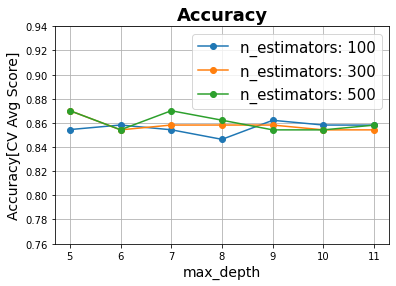

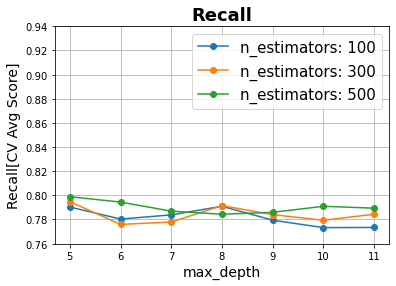

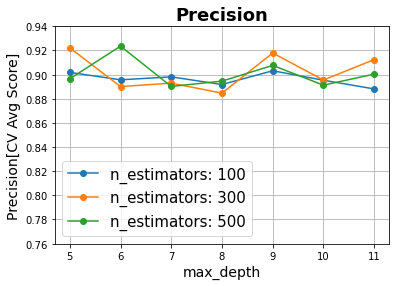

In [17]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, titre):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_1), len(grid_param_2))
    scores_mean= scores_mean.T
    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.set_ylim([0.76,0.94])
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
        #ax.plot(19, scores_mean[idx, -1:], '*', label= 'crt' + '=' + str(val) + ' & mx_dpt=None')
        
    ax.set_title(titre, fontsize=18, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=14)
    ax.set_ylabel(titre+'[CV Avg Score]', fontsize=14)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
# Calling Method 
plot_grid_search(grid_search_acc.cv_results_, params['classifier__max_depth'], params['classifier__n_estimators'],  'max_depth', 'n_estimators', 'Accuracy')
plot_grid_search(grid_search_rec.cv_results_, params['classifier__max_depth'], params['classifier__n_estimators'],  'max_depth', 'n_estimators', 'Recall')
plot_grid_search(grid_search_prec_avg.cv_results_, params['classifier__max_depth'], params['classifier__n_estimators'], 'max_depth', 'n_estimators', 'Precision')

In [11]:
## evaluating the model
print('best parameters: ', grid_search_acc.best_params_)

best parameters:  {'classifier__max_depth': 5, 'classifier__n_estimators': 300}


In [12]:
## return index for dataframe
def return_index_list(param1, param2):
    list=[]
    for p1 in param1:
        for p2 in param2:
            list.append('['+str(p1)+', '+str(p2)+']')
    return list
index= return_index_list(params['classifier__max_depth'], params['classifier__n_estimators'])

In [14]:
df= pd.DataFrame({  'Accuracy': grid_search_acc.cv_results_['mean_test_score'],
                    'Precision(Avg)': grid_search_prec_avg.cv_results_['mean_test_score'],
                    'Recall(Avg)': grid_search_rec.cv_results_['mean_test_score'],
                     'std_cross_validation': grid_search_acc.cv_results_['std_test_score']},
                 index=index)
df

,Accuracy,Precision(Avg),Recall(Avg),std_cross_validation
"[5, 100]",0.854431,0.901770,0.790338,0.026124
"[5, 300]",0.870118,0.922073,0.794830,0.031699
"[5, 500]",0.870118,0.896488,0.798870,0.031699
"[6, 100]",0.858196,0.895631,0.780385,0.019757
"[6, 300]",0.854196,0.890038,0.775941,0.047870
"[6, 500]",0.854275,0.923511,0.794426,0.023874
"[7, 100]",0.854275,0.898072,0.783823,0.040577
"[7, 300]",0.858196,0.892882,0.777910,0.029184
"[7, 500]",0.870039,0.890148,0.786903,0.029513
"[8, 100]",0.846353,0.891749,0.790941,0.038481


In [16]:
## to excel
writer = pd.ExcelWriter('XGBoost.xlsx')
df.to_excel(writer, 'XGBoost')
writer.save()
writer.close()

In [18]:
#evaluation
predicted = grid_search_acc.best_estimator_.predict(X_test)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.88
Detail:
              precision    recall  f1-score   support

   formation       0.84      0.98      0.91        63
   scolarité       0.94      0.64      0.76        25
       sport       1.00      1.00      1.00        14
   événement       1.00      0.57      0.73         7

    accuracy                           0.88       109
   macro avg       0.94      0.80      0.85       109
weighted avg       0.89      0.88      0.87       109



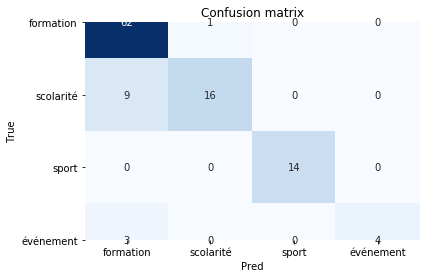

In [27]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()